In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Define gridworld

In [39]:
# Define mappings
state_to_idx = {(0,0):0, (0,1):1, (1,0):2, (1,1):3}
idx_to_state = {v:k for k,v in state_to_idx.items()}
actions = ['up', 'down', 'left', 'right']
action_to_idx = {a: i for i, a in enumerate(actions)}

# One-hot encodings
def one_hot(index, size):
    vec = torch.zeros(size)
    vec[index] = 1.0
    return vec

# Environment simulator
class SimpleGridWorld2x2:
    def __init__(self):
        self.grid_size = (2, 2)
        self.actions = actions

    def step(self, state, action):
        x, y = state
        if action == 'up':
            x = max(0, x - 1)
        elif action == 'down':
            x = min(1, x + 1)
        elif action == 'left':
            y = max(0, y - 1)
        elif action == 'right':
            y = min(1, y + 1)
        return (x, y)

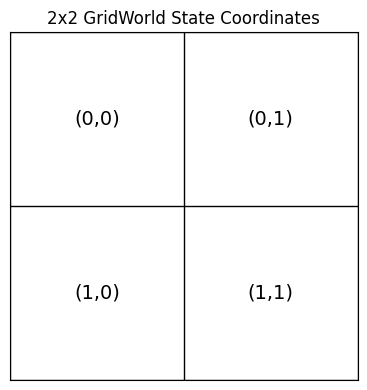

In [41]:
def plot_gridworld_2x2():
    fig, ax = plt.subplots(figsize=(4, 4))

    # Draw grid lines
    for x in range(3):
        ax.plot([0, 2], [x, x], 'k-', lw=1)
        ax.plot([x, x], [0, 2], 'k-', lw=1)

    # Place coordinate labels
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, 1.5 - i, f"({i},{j})", ha='center', va='center', fontsize=14)

    # Formatting
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title("2x2 GridWorld State Coordinates")
    plt.tight_layout()
    plt.show()

plot_gridworld_2x2()


### Implementing an RNN on it

In [40]:
class GridRNN(nn.Module):
    def __init__(self, input_size=8, hidden_size=16, output_size=4): # Input size is 8 (4 for state + 4 for action); output size is 4 (one of the possible next states)
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

# Training loop
def train_rnn(env, model, optimizer, criterion, epochs=1000):
    for epoch in range(epochs):
        state = random.choice(list(state_to_idx.keys()))
        action = random.choice(actions)
        next_state = env.step(state, action)

        # Prepare input and target
        state_vec = one_hot(state_to_idx[state], 4)
        action_vec = one_hot(action_to_idx[action], 4)
        input_vec = torch.cat([state_vec, action_vec]).unsqueeze(0).unsqueeze(0)  # (1, 1, 8)
        target = torch.tensor([[state_to_idx[next_state]]])  # (1, 1)

        # Forward
        logits, _ = model(input_vec)
        loss = criterion(logits.squeeze(0), target.squeeze(0))

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Initialize
env = SimpleGridWorld2x2()
model = GridRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train
train_rnn(env, model, optimizer, criterion)


Epoch 0, Loss: 1.1739
Epoch 200, Loss: 0.0844
Epoch 400, Loss: 0.0313
Epoch 600, Loss: 0.0102
Epoch 800, Loss: 0.0085


### Extract hidden representations

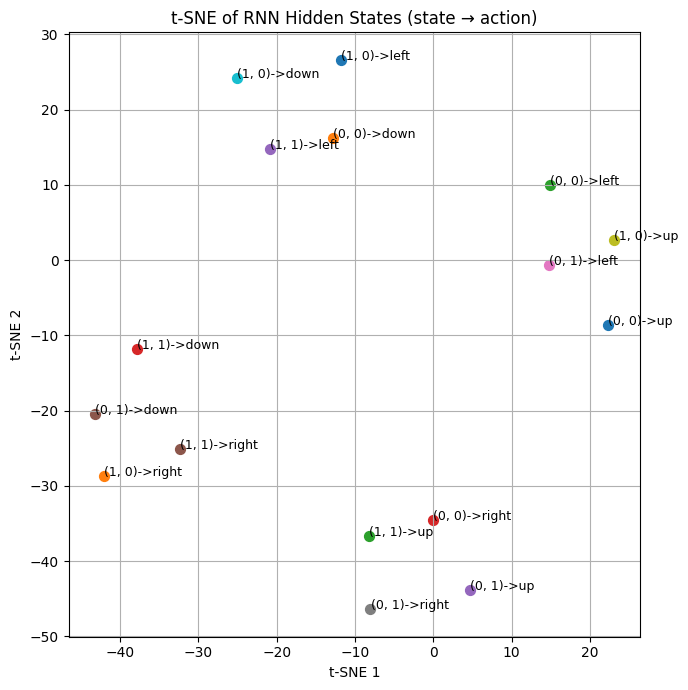

In [ ]:
hidden_states = []
labels = []

with torch.no_grad():
    for s in state_to_idx:
        for a in actions:
            s_vec = one_hot(state_to_idx[s], 4)
            a_vec = one_hot(action_to_idx[a], 4)
            x = torch.cat([s_vec, a_vec]).unsqueeze(0).unsqueeze(0)  # (1, 1, 8)
            _, h = model(x)
            hidden_states.append(h.squeeze(0).squeeze(0).numpy())  # (hidden_size,)
            labels.append(f"{s}->{a}")

# t-SNE visualization
hidden_states_np = np.array(hidden_states)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
z = tsne.fit_transform(hidden_states_np)

plt.figure(figsize=(7,7))
for i, label in enumerate(labels):
    plt.scatter(z[i, 0], z[i, 1], s=50)
    plt.text(z[i, 0] + 0.01, z[i, 1] + 0.01, label, fontsize=9)
plt.title("t-SNE of RNN Hidden States (state → action)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()